# 1. 라이브러리

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
!pip install transformers

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
import re
import tensorflow as tf
warnings.filterwarnings('ignore')
# 한글 지원 폰트
plt.rc('font', family='NanumBarunGothic')
# 마이너스 부호 
plt.rcParams['axes.unicode_minus'] = False

# 2. 데이터 불러오기

In [5]:
data = pd.read_csv('/content/drive/MyDrive/아이펠톤/DKTC data/train.csv')
data.head(5)

,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


In [9]:
data.isnull().sum()

idx             0
class           0
conversation    0
dtype: int64

# 3. 전처리

In [8]:
def preprocess(sen):
    sen = re.sub('\n', '', sen)
    return sen

data['conversation'] = data['conversation'].apply(lambda x: preprocess(x))
data.head(3)

,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가? 아닙니다. 죄송합니다. 죽을 거면 혼...
1,1,협박 대화,길동경찰서입니다.9시 40분 마트에 폭발물을 설치할거다.네?똑바로 들어 한번만 더 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.그만해. 니들 놀리는거 재미없어...


# 4. 라벨인코딩

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(data['class'])

In [11]:
label_encoder.classes_

array(['갈취 대화', '기타 괴롭힘 대화', '직장 내 괴롭힘 대화', '협박 대화'], dtype=object)

In [12]:
label_encoder.transform(data['class'])

array([3, 3, 1, ..., 2, 0, 2])

In [14]:
data['class'] = label_encoder.transform(data['class'])

In [15]:
data.head()

,idx,class,conversation
0,0,3,지금 너 스스로를 죽여달라고 애원하는 것인가? 아닙니다. 죄송합니다. 죽을 거면 혼...
1,1,3,길동경찰서입니다.9시 40분 마트에 폭발물을 설치할거다.네?똑바로 들어 한번만 더 ...
2,2,1,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.그만해. 니들 놀리는거 재미없어...
3,3,0,어이 거기예??너 말이야 너. 이리 오라고무슨 일.너 옷 좋아보인다?얘 돈 좀 있나...
4,4,0,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


# 5. train, validation, test 분리

In [19]:
from sklearn.model_selection import train_test_split

train = data['conversation'].tolist()
target = data['class'].tolist()

# train, val 분리 (20%)
train_x, val_x, train_y, val_y = train_test_split(train, target, random_state=27, test_size=0.2)
# val, test 분리 (test를 전체의 10%)
val_x, test_x, val_y, test_y = train_test_split(val_x, val_y, random_state=27, test_size=0.5)

In [20]:
len(train_x), len(val_x), len(test_x)

(3160, 395, 395)

# 6. 토크나이징

In [21]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('klue/bert-base')

train_tensor = tokenizer(train_x, truncation=True, padding=True)
val_tensor = tokenizer(val_x, truncation=True, padding=True)

Downloading:   0%|          | 0.00/248k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/289 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/425 [00:00<?, ?B/s]

In [30]:
len(val_tensor['input_ids'])

395

In [31]:
len(train_tensor['input_ids'])

3160

# 7. 입력데이터셋 생성

In [34]:
# trainset-set
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_tensor),
    train_y
))

# validation-set
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_tensor),
    val_y
))

In [36]:
train_dataset

<TensorSliceDataset element_spec=({'input_ids': TensorSpec(shape=(458,), dtype=tf.int32, name=None), 'token_type_ids': TensorSpec(shape=(458,), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(458,), dtype=tf.int32, name=None)}, TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [35]:
val_dataset

<TensorSliceDataset element_spec=({'input_ids': TensorSpec(shape=(363,), dtype=tf.int32, name=None), 'token_type_ids': TensorSpec(shape=(363,), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(363,), dtype=tf.int32, name=None)}, TensorSpec(shape=(), dtype=tf.int32, name=None))>

# 8. 모델 컴파일

In [37]:
from transformers import TFBertForSequenceClassification

model = TFBertForSequenceClassification.from_pretrained('klue/bert-base', num_labels=4, from_pt=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
model.compile(optimizer=optimizer, loss=model.hf_compute_loss, metrics=['accuracy'])

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [39]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  110617344 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  3076      
                                                                 
Total params: 110,620,420
Trainable params: 110,620,420
Non-trainable params: 0
_________________________________________________________________


# 9. 훈련

In [41]:
history = model.fit(
    train_dataset.shuffle(len(train_dataset)).batch(8), epochs=1, batch_size=8,
    validation_data=val_dataset.shuffle(len(val_dataset)).batch(8),
)

395/395 [==============================] - 352s 891ms/step - loss: 0.4728 - accuracy: 0.8342 - val_loss: 0.3373 - val_accuracy: 0.8987


In [42]:
model.config.id2label

{0: 'LABEL_0', 1: 'LABEL_1', 2: 'LABEL_2', 3: 'LABEL_3'}

In [43]:
id2labels = model.config.id2label
model.config.id2label = {id : label_encoder.inverse_transform([int(re.sub('LABEL_', '', label))])[0]  for id, label in id2labels.items()}

label2ids = model.config.label2id
model.config.label2id = {label_encoder.inverse_transform([int(re.sub('LABEL_', '', label))])[0] : id   for id, label in id2labels.items()}

In [44]:
model.config.id2label

{0: '갈취 대화', 1: '기타 괴롭힘 대화', 2: '직장 내 괴롭힘 대화', 3: '협박 대화'}

# 10. 모델 저장

In [45]:
MODEL_SAVE_PATH = '/content/drive/MyDrive/아이펠톤/미니아펠톤/klue-bert-base2'

# save tokenizer, model
model.save_pretrained(MODEL_SAVE_PATH)
tokenizer.save_pretrained(MODEL_SAVE_PATH)

('/content/drive/MyDrive/아이펠톤/미니아펠톤/klue-bert-base2/tokenizer_config.json',
 '/content/drive/MyDrive/아이펠톤/미니아펠톤/klue-bert-base2/special_tokens_map.json',
 '/content/drive/MyDrive/아이펠톤/미니아펠톤/klue-bert-base2/vocab.txt',
 '/content/drive/MyDrive/아이펠톤/미니아펠톤/klue-bert-base2/added_tokens.json')

# 11. 모델 LOAD

In [46]:
from transformers import TextClassificationPipeline

# Load Fine-tuning model
loaded_tokenizer = BertTokenizer.from_pretrained(MODEL_SAVE_PATH)
loaded_model = TFBertForSequenceClassification.from_pretrained(MODEL_SAVE_PATH)

text_classifier = TextClassificationPipeline(
    tokenizer=loaded_tokenizer, 
    model=loaded_model, 
    framework='tf',
    top_k=None
)

Some layers from the model checkpoint at /content/drive/MyDrive/아이펠톤/미니아펠톤/klue-bert-base2 were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/아이펠톤/미니아펠톤/klue-bert-base2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [50]:
text_classifier(test_x[0])

[[{'label': '직장 내 괴롭힘 대화', 'score': 0.9910129904747009},
  {'label': '협박 대화', 'score': 0.0035972229670733213},
  {'label': '기타 괴롭힘 대화', 'score': 0.0028395268600434065},
  {'label': '갈취 대화', 'score': 0.002550225704908371}]]

# 12. 예측

In [62]:
predicted_list = []

for text in test_x:
    # predict
    preds_list = text_classifier(text)[0]
    sorted_preds_list = sorted(preds_list, key=lambda x: x['score'], reverse=True)
    predicted_list.append(sorted_preds_list[0])

In [63]:
test_df = pd.DataFrame(predicted_list)
test_y = label_encoder.inverse_transform(test_y)
test_df['true_label'] = test_y
test_df.head()

,label,score,true_label
0,직장 내 괴롭힘 대화,0.991013,직장 내 괴롭힘 대화
1,협박 대화,0.965478,갈취 대화
2,기타 괴롭힘 대화,0.600571,기타 괴롭힘 대화
3,직장 내 괴롭힘 대화,0.986653,직장 내 괴롭힘 대화
4,직장 내 괴롭힘 대화,0.994765,직장 내 괴롭힘 대화


In [67]:
test_df = test_df[['true_label','label','score']]
test_df.head()

,true_label,label,score
0,직장 내 괴롭힘 대화,직장 내 괴롭힘 대화,0.991013
1,갈취 대화,협박 대화,0.965478
2,기타 괴롭힘 대화,기타 괴롭힘 대화,0.600571
3,직장 내 괴롭힘 대화,직장 내 괴롭힘 대화,0.986653
4,직장 내 괴롭힘 대화,직장 내 괴롭힘 대화,0.994765


In [68]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_true=test_df['true_label'], y_pred=test_df['label']))

              precision    recall  f1-score   support

       갈취 대화       0.93      0.77      0.84        90
   기타 괴롭힘 대화       0.93      0.88      0.91       104
 직장 내 괴롭힘 대화       0.86      1.00      0.92       103
       협박 대화       0.86      0.90      0.88        98

    accuracy                           0.89       395
   macro avg       0.90      0.89      0.89       395
weighted avg       0.89      0.89      0.89       395



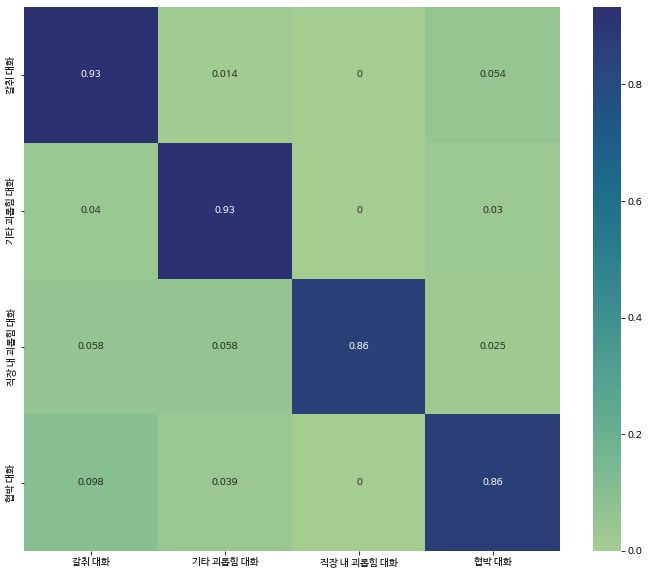

In [69]:
confusion_m = confusion_matrix(test_df['label'], test_df['true_label'], normalize='true')

plt.figure(figsize=(12,10))
sns.heatmap(confusion_m, annot=True, xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap="crest")
plt.show()